In [3]:
import os
import shutil

SOURCE_BASE = "/kaggle/input/plant-village-dataset-updated"

DEST_BASE = "/kaggle/working/plant-village-merged"

plants = [
    "Apple",
    "Bell Pepper",
    "Cherry",
    "Corn (Maize)",
    "Grape",
    "Peach",
    "Potato",
    "Strawberry",
    "Tomato"
]

splits = ["Train", "Val", "Test"]


for split in splits:
    os.makedirs(os.path.join(DEST_BASE, split), exist_ok=True)


for plant in plants:
    for split in splits:
        plant_split_dir = os.path.join(SOURCE_BASE, plant, split)
        if not os.path.isdir(plant_split_dir):
            continue
        
        # Each disease folder inside Apple/Train, Apple/Val, etc.
        for disease in os.listdir(plant_split_dir):
            disease_folder = os.path.join(plant_split_dir, disease)
            if not os.path.isdir(disease_folder):
                continue
            
            # Make a combined class name to avoid collisions:
            # e.g., "Apple_Apple Scab"
            combined_class_name = f"{plant}_{disease}"
            
            # Create the destination subfolder
            dest_class_dir = os.path.join(DEST_BASE, split, combined_class_name)
            os.makedirs(dest_class_dir, exist_ok=True)
            
            # Copy all images
            for img_name in os.listdir(disease_folder):
                src_path = os.path.join(disease_folder, img_name)

                if os.path.isdir(src_path):
                    continue
                
                dst_path = os.path.join(dest_class_dir, img_name)
                # Copy or move the image (copy2 preserves metadata)
                shutil.copy2(src_path, dst_path)

print("Merging complete!")


import os

def count_images_in_folder(folder_path):
    """Count the number of image files in a folder (recursively)."""
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(valid_extensions):
                count += 1
    return count

# Paths to your flattened dataset splits
train_path = '/kaggle/working/plant-village-merged/Train'
val_path   = '/kaggle/working/plant-village-merged/Val'
test_path  = '/kaggle/working/plant-village-merged/Test'

# Count images in each split
train_count = count_images_in_folder(train_path)
val_count   = count_images_in_folder(val_path)
test_count  = count_images_in_folder(test_path)

print("Total training images:  ", train_count)
print("Total validation images:", val_count)
print("Total testing images:   ", test_count)

Merging complete!
Total training images:   53690
Total validation images: 12067
Total testing images:    1354


Found 1354 images belonging to 29 classes.
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Test Accuracy: 0.9823
Classification Report:
                                   precision    recall  f1-score   support

                 Apple_Apple Scab       1.00      0.98      0.99        51
                  Apple_Black Rot       0.96      1.00      0.98        50
           Apple_Cedar Apple Rust       1.00      1.00      1.00        44
                    Apple_Healthy       1.00      1.00      1.00        51
       Bell Pepper_Bacterial Spot       1.00      0.96      0.98        48
              Bell Pepper_Healthy       1.00      1.00      1.00        50
                   Cherry_Healthy       0.98      1.00      0.99        46
            Cherry_Powdery Mildew       1.00      1.00      1.00        43
Corn (Maize)_Cercospora Leaf Spot       0.95      0.98      0.96        41
        Corn (Maize)_Common Rust        1.00      1.00      1.00        48
             Corn (Maize)_Healthy       1.00  

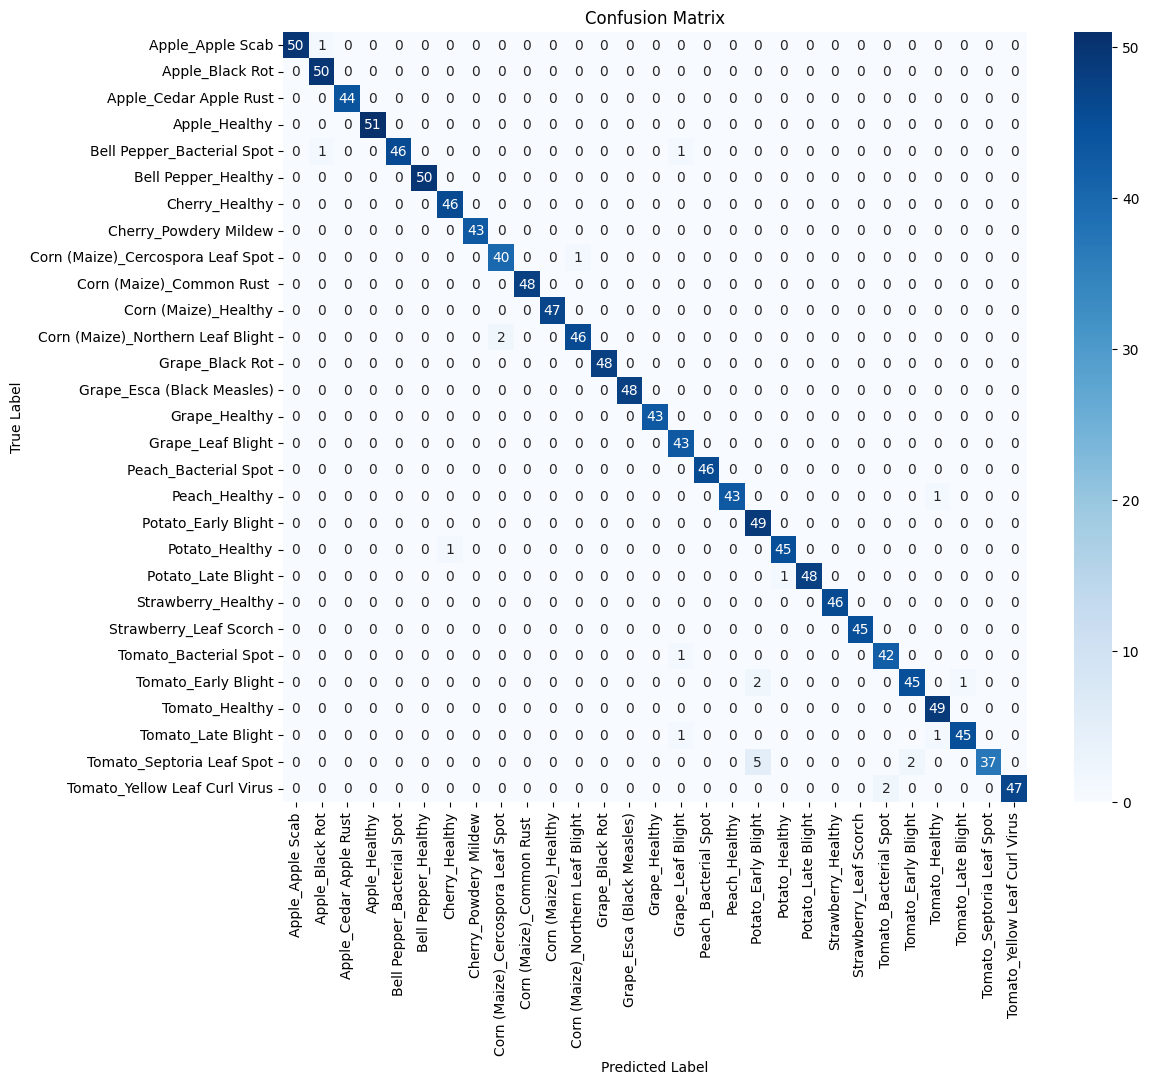

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1) Load your model
model_path = '/kaggle/input/diseasedetect/tensorflow2/default/1/student_model.h5'
model = load_model(model_path)

# 2) Build a test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    '/kaggle/working/plant-village-merged/Test',
    target_size=(128, 128), 
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


# 3) Run predict
raw_preds = model.predict(test_gen, verbose=1)

# 4) Unpack the actual predictions
if isinstance(raw_preds, list) and len(raw_preds) >= 2:
    preds = raw_preds[1]
else:
    preds = raw_preds

# 5) Convert to label indices
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# 6) Compute overall accuracy
acc = np.mean(y_pred == y_true)
print(f"Test Accuracy: {acc:.4f}")

# 7) Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 8) Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()